# Imports

In [25]:
import sys
sys.path.append('/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/scripts/')
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import torch
from model import SpeakerClassifier

# Functions

In [2]:
def load_labels(paths):
    
    labels = []
    for path in paths:
        with open(path, 'r') as data_labels_file:
            labels = labels + data_labels_file.readlines()
    return labels

In [3]:
def format_audio_path(audio_path, prepend_directories):

    # we need to remove the first "/" to join paths
    if audio_path[0] == "/":
        audio_path = audio_path[1:]

    # remove the file extension, if has
    if len(audio_path.split(".")) > 1:
        audio_path = '.'.join(audio_path.split(".")[:-1]) 

    # We prepend prepend_directory to the paths and the file extension
    data_founded = False
    for dir in prepend_directories:

        if data_founded == False:

            for audio_format in ['wav', 'm4a']:

                audio_file = f"{audio_path}.{audio_format}"
                complete_audio_file_path = os.path.join(dir, audio_file)

                if os.path.exists(complete_audio_file_path):
                    data_founded = True
                    break

    assert data_founded, f"{audio_path} not founded."

    return complete_audio_file_path

In [4]:
def get_audio_paths(labels_list, prepend_directories):

    audio_paths = []
    total_lines = len(labels_list)
    progress_pctg_to_print = 0
    for index, label in enumerate(labels_list):

        label = label.replace('\n', '')
        label_chunks = label.split(' ')

        if len(label_chunks) == 3:

            # Training labels:
            # label is of the form '/speaker/interview/file speaker_number -1'
            audio_path = label_chunks[0]
            audio_path = format_audio_path(audio_path, prepend_directories)
            audio_paths.append(audio_path)

        elif len(label_chunks) == 2:

            # Validation or Test labels
            # label is of the form '/speaker/interview/file /speaker/interview/file'
            audio_path_1, audio_path_2 = label_chunks
            audio_path_1 = format_audio_path(audio_path_1, prepend_directories)
            audio_path_2 = format_audio_path(audio_path_2, prepend_directories)
            audio_paths.append(audio_path_1)
            audio_paths.append(audio_path_2)

        else:

            assert False, f"{label} has a not expected structure."

        progress_pctg = index / total_lines * 100
        if progress_pctg >=  progress_pctg_to_print:
            #print(f"{progress_pctg:.0f}% paths processed...")
            progress_pctg_to_print = progress_pctg_to_print + 1
            
    return audio_paths

# Settings

In [5]:
prepend_directories = [
    '/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCeleb2/dev/',
]

labels_file_name = [
    '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/labels/valid/voxceleb_2/22_12_09_12_41_06_12nc5wq4_fiery-donkey-13/clients.ndx',
    '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/labels/valid/voxceleb_2/22_12_09_12_41_29_ikfavyhj_ruby-microwave-14/impostors.ndx',
]

# Analysis

In [6]:
labels_list = load_labels(labels_file_name)

In [7]:
audio_paths = get_audio_paths(labels_list, prepend_directories)

In [8]:
df = pd.DataFrame({"audio_path" : audio_paths[:1000]})

In [9]:
def get_speaker(audio_path):
    
    speaker_chunk = [chunk for chunk in audio_path.split("/") if chunk.startswith("id")]
    # Only consider directories with /id.../
    if len(speaker_chunk) > 0: 
        speaker = speaker_chunk[0]
    
    return speaker

In [10]:
def get_duration(audio_path):

    audio_duration = librosa.get_duration(filename = audio_path)
    
    return audio_duration

In [11]:
df["speaker"] = df["audio_path"].apply(lambda x: get_speaker(x))

In [12]:
%%time

df["duration_seconds"] = df["audio_path"].apply(lambda x: get_duration(x))

CPU times: user 7.36 s, sys: 1.9 s, total: 9.26 s
Wall time: 1min 16s


In [13]:
df.head()

,audio_path,speaker,duration_seconds
0,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id08821,8.3
1,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id08821,4.5
2,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id04274,12.3
3,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id04274,11.2
4,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id08637,7.2


In [14]:
number_of_speakers = df["speaker"].nunique()
total_files = len(df)
total_duration_hours = sum(df["duration_seconds"]) / 3600

In [15]:
total_files

1000

In [16]:
total_duration_hours

2.0356944444444456

In [17]:
df.sort_values("duration_seconds", ascending = True, inplace = True)

In [18]:
df["duration_seconds_cumsum"] = df["duration_seconds"].cumsum() / df["duration_seconds"].sum() * 100

In [19]:
df.head()

,audio_path,speaker,duration_seconds,duration_seconds_cumsum
783,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id00933,3.9,0.053217
196,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id02098,3.9,0.106434
33,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id08078,3.9,0.159651
325,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id08723,3.9,0.212868
184,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id07204,3.9,0.266084


In [20]:
df["duration_seconds"].describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count    1000.000000
mean        7.328500
std         4.200174
min         3.900000
1%          3.900000
5%          4.100000
25%         4.700000
50%         5.900000
75%         8.400000
95%        15.510000
99%        23.901000
max        49.300000
Name: duration_seconds, dtype: float64

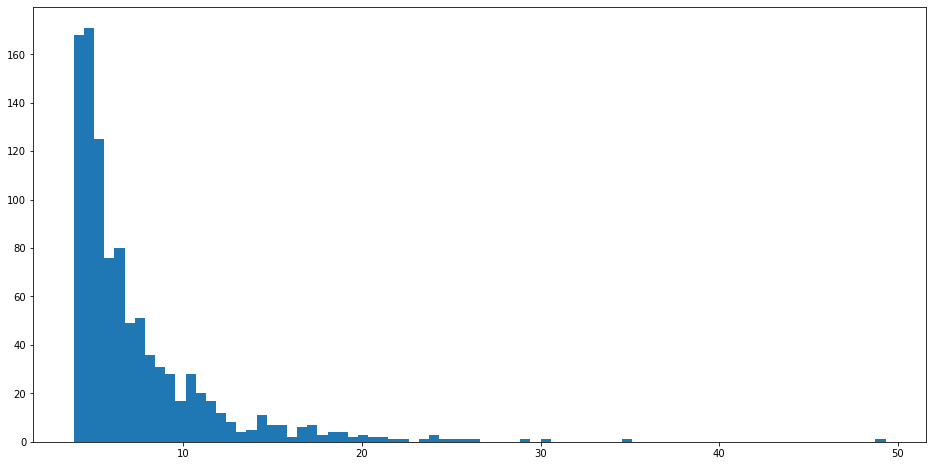

In [21]:
plt.figure(figsize = (16,8))

plt.hist(df["duration_seconds"], bins = 80)

plt.show()

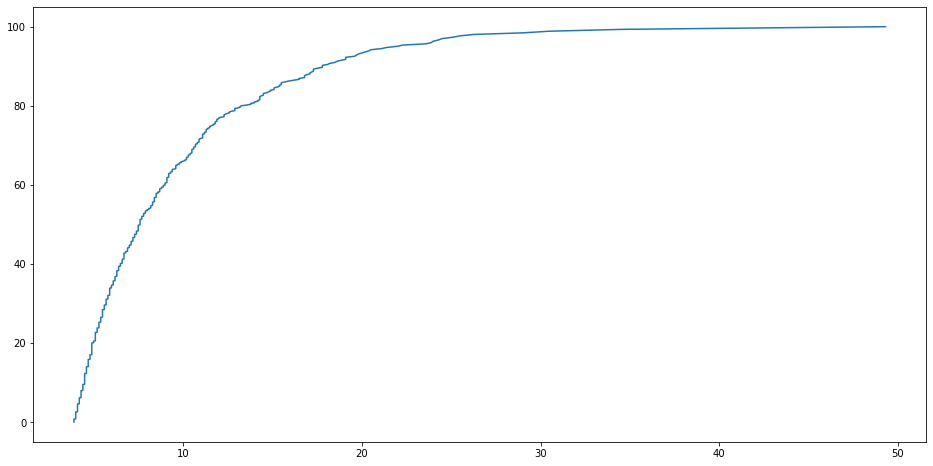

In [22]:
plt.figure(figsize = (16,8))

plt.plot(df["duration_seconds"], df["duration_seconds_cumsum"])

plt.show()

In [26]:
checkpoint_path = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/models/22_12_14_09_48_59_vgg_tmh_ap_fc_VGGNL_TransformerStackedAttentionPooling_c0whzsyq/22_12_14_09_48_59_vgg_tmh_ap_fc_VGGNL_TransformerStackedAttentionPooling_c0whzsyq.chkpt'


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = torch.load(checkpoint_path, map_location = device)
params = checkpoint['settings']

net = SpeakerClassifier(params, device)

try:
    net.load_state_dict(checkpoint['model'])
except RuntimeError:    
    net.module.load_state_dict(checkpoint['model'])

In [ ]:
with torch.no_grad():

    # Switch torch to evaluation mode
    self.net.eval()

In [28]:
df.sample()

,audio_path,speaker,duration_seconds,duration_seconds_cumsum
932,/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCel...,id03318,4.4,8.159924
